# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Include transformations and interactions, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
6. Summarize your results from 1 to 5. Have you learned anything about overfitting and underfitting, or model selection?
7. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.



In [1]:
! git clone https://github.com/vrhughes/labs

Cloning into 'labs'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 163 (delta 67), reused 76 (delta 43), pack-reused 55 (from 1)
Receiving objects: 100% (163/163), 4.38 MiB | 6.16 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# Import stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Question 1
data = pd.read_csv('/content/labs/04_hedonic_pricing/pierce_county_house_sales.csv', low_memory=False) # so pandas does not complain about pulling all this stuff at once

data.head()

,sale_date,sale_price,house_square_feet,attic_finished_square_feet,basement_square_feet,attached_garage_square_feet,detached_garage_square_feet,fireplaces,hvac_description,exterior,interior,stories,roof_cover,year_built,bedrooms,bathrooms,waterfront_type,view_quality,utility_sewer
0,2020-01-02,380000,2157,0,0,528,0,0,Warm and Cool Air Zone,Frame Siding,Drywall,2,Composition Shingle,1993,3,3,NaN,NaN,SEWER/SEPTIC INSTALLED
1,2020-01-02,383000,2238,0,0,396,0,0,Forced Air,Frame Siding,Drywall,2,Composition Shingle,2017,4,3,NaN,NaN,SEWER/SEPTIC INSTALLED
2,2020-01-01,419900,1452,0,0,0,0,1,Forced Air,Frame Siding,Drywall,1,Built Up Rock,1965,3,2,NaN,NaN,SEWER/SEPTIC INSTALLED
3,2020-01-02,251660,832,0,0,0,0,0,Forced Air,Frame Vinyl,Drywall,1,Composition Shingle,1919,2,1,NaN,NaN,SEWER/SEPTIC INSTALLED
4,2020-01-02,500000,1780,0,384,484,0,1,Forced Air,Frame Siding,Drywall,1,Composition Shingle,1955,3,2,NaN,NaN,SEWER/SEPTIC INSTALLED


In [4]:
# taking the housing data we care about
houses = data[['sale_price', 'house_square_feet', 'year_built', 'bedrooms', 'bathrooms']]
print(houses.describe(), '\n') # seeing it in action

# Question 2
# print type of column for houses
print(houses.dtypes, '\n') # slay they are all ints

# find missing values for houses columns
print(houses.isnull().sum(), '\n') # no missing values!

# getting rid of rows in houses where bedrooms or bathrooms is zero, and sqft is less than 10
houses = houses[(houses['bedrooms'] > 0) & (houses['bathrooms'] > 0) & (houses['house_square_feet'] > 10)]
print(houses.describe(), '\n') # got rid of like 60 ish houses


         sale_price  house_square_feet    year_built      bedrooms  \
count  1.681400e+04       16814.000000  16814.000000  16814.000000   
mean   4.612332e+05        1879.941953   1980.469252      3.277983   
std    2.360833e+05         760.419008     33.339025      0.891240   
min    2.000000e+03           1.000000   1880.000000      0.000000   
25%    3.480000e+05        1320.000000   1959.000000      3.000000   
50%    4.165000e+05        1774.000000   1990.000000      3.000000   
75%    5.238065e+05        2352.000000   2006.000000      4.000000   
max    6.130000e+06        9510.000000   2021.000000     25.000000   

          bathrooms  
count  16814.000000  
mean       2.317176  
std        0.827956  
min        0.000000  
25%        2.000000  
50%        2.000000  
75%        3.000000  
max        8.000000   

sale_price           int64
house_square_feet    int64
year_built           int64
bedrooms             int64
bathrooms            int64
dtype: object 

sale_price        

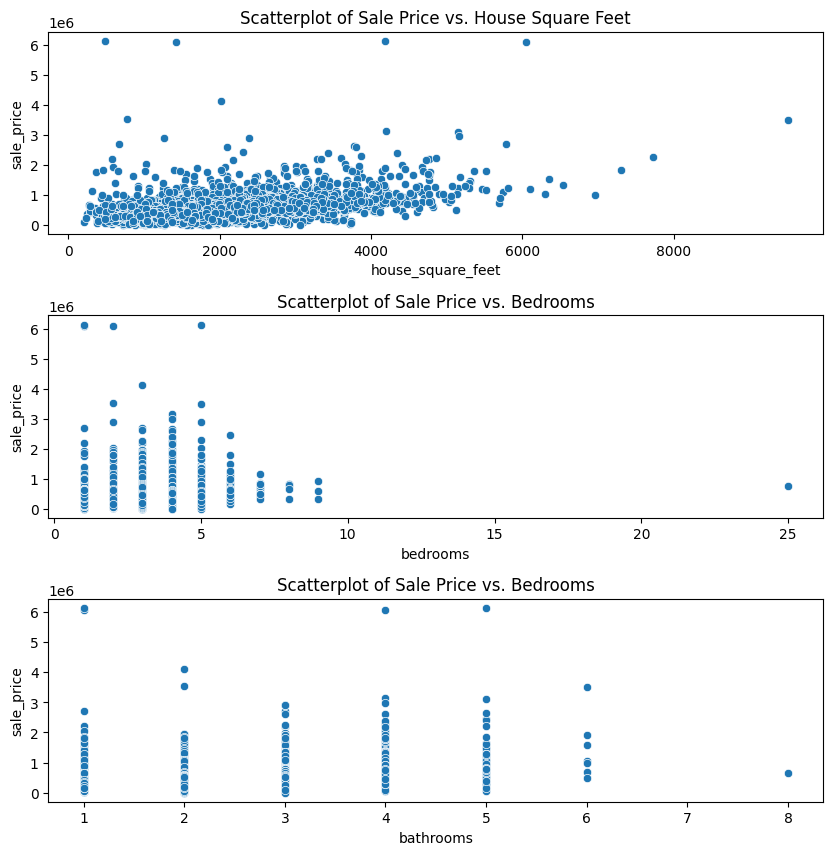

In [8]:
# initial plotting
fig, ax = plt.subplots(3, 1, figsize=(10,10))
sns.scatterplot(x = houses['house_square_feet'], y = houses['sale_price'], ax = ax[0])
ax[0].set_title('Scatterplot of Sale Price vs. House Square Feet')

sns.scatterplot(x = houses['bedrooms'], y = houses['sale_price'], ax = ax[1])
ax[1].set_title('Scatterplot of Sale Price vs. Bedrooms')

sns.scatterplot(x = houses['bathrooms'], y = houses['sale_price'], ax = ax[2])
ax[2].set_title('Scatterplot of Sale Price vs. Bedrooms')

plt.subplots_adjust(hspace=0.4)
plt.show()

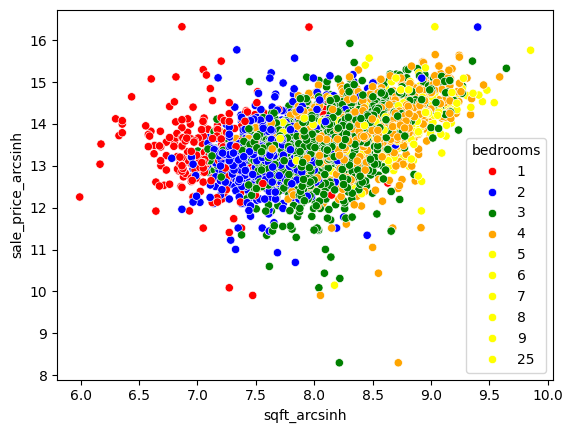

In [10]:
# initial plotting continued
houses['sale_price_arcsinh'] = np.arcsinh(houses['sale_price'])
other = [5, 6, 7, 8, 9, 25]
palette = {1:'red', 2:'blue', 3:'green', 4:'orange', **{k: 'yellow' for k in other}}
houses['sqft_arcsinh'] = np.arcsinh(houses['house_square_feet'])

sns.scatterplot(data=houses, x='sqft_arcsinh',  y='sale_price_arcsinh', hue='bedrooms', palette=palette)
plt.show()


This looks better compared to

In [6]:
# adding maxmin func from notes
def maxmin(z):
    w = (z-np.min(z))/(np.max(z)-np.min(z))
    return w

In [11]:
# Question 3: train test split
price = houses['sale_price_arcsinh'] # or 'sale_price'?

features = houses.loc[:, ['house_square_feet', 'year_built', 'bedrooms', 'bathrooms']] # features matrix
features = features.apply(maxmin) # normalizing features (will become X)
features.head()
features.describe()

X_train, X_test, y_train, y_test = train_test_split(features, price, test_size=0.2, random_state=100)

INTERACTING FEATURESSSSS

In [12]:
# Question 4: Build simple linear models w/ no transf or interactions.
#   Determine RMSE and R^2 on both training and test sets. Which model does best?

# training set
training = LinearRegression().fit(X_train, y_train)
print('Training Intercept: ', training.intercept_)
print('Training Coefficients: ', training.coef_)
print('Training R^2: ', training.score(X_train, y_train))
ytr_hat = training.predict(X_train.values)
train_rmse = np.sqrt( np.mean( (y_train - ytr_hat)**2 ))
print('Training RMSE: ', train_rmse)


Training Intercept:  13.184174031798339
Training Coefficients:  [ 2.69887638 -0.06776127 -1.03763135  0.64688517]
Training R^2:  0.3501774246146059
Training RMSE:  0.33944337895679166


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [13]:
# Question 4 continued
# test set
test = LinearRegression().fit(X_test, y_test)
print('Test Intercept: ', test.intercept_)
print('Test Coefficients: ', test.coef_)
print('Test R^2: ', test.score(X_test, y_test))
yte_hat = test.predict(X_test.values)
test_rmse = np.sqrt( np.mean( (y_test - yte_hat)**2 ))
print('Training RMSE: ', test_rmse)

Test Intercept:  13.17004074380138
Test Coefficients:  [ 2.78489309 -0.05923933 -1.15655964  0.64217926]
Test R^2:  0.36655607002332047
Training RMSE:  0.3424501275071374


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


The training and test sets performed pretty similarly. The test data did yield slightly better R^2 and RMSE values though, this could imply that there is a little overfitting occurring.

In [ ]:
from re import X
# Question 5: include transf and interactions, build a more complex model.
#   Again determine R^2 and RMSE on training and test.

# bedrooms*bathrooms col added to X_train
X_train['bedroomsxbathrooms'] = X_train['bedrooms'] * X_train['bathrooms']
X_test['bedroomsxbathrooms'] = X_test['bedrooms'] * X_test['bathrooms']